<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [1]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from google_drive_downloader import GoogleDriveDownloader as gdd
from sklearn.model_selection import cross_val_score
import seaborn as sns

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer

In [ ]:
! pip install catboost
from catboost import CatBoostClassifier

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [3]:
data = pd.read_csv('./train_dls3.csv') 

In [4]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [5]:
# На первый взягляд пропусков нет, но они рячутся в " ", пожтому заменим на NaN
data = data.replace(' ', np.NaN)

In [6]:
# теперь пропуски видны
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5273 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [7]:
# Столбец 'TotalSpent' относится к numerical признакам, но значения - строки, поэтому преобразуем к float.
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], downcast='float')

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

In [8]:
data['Sex'].unique()

array(['Male', 'Female'], dtype=object)

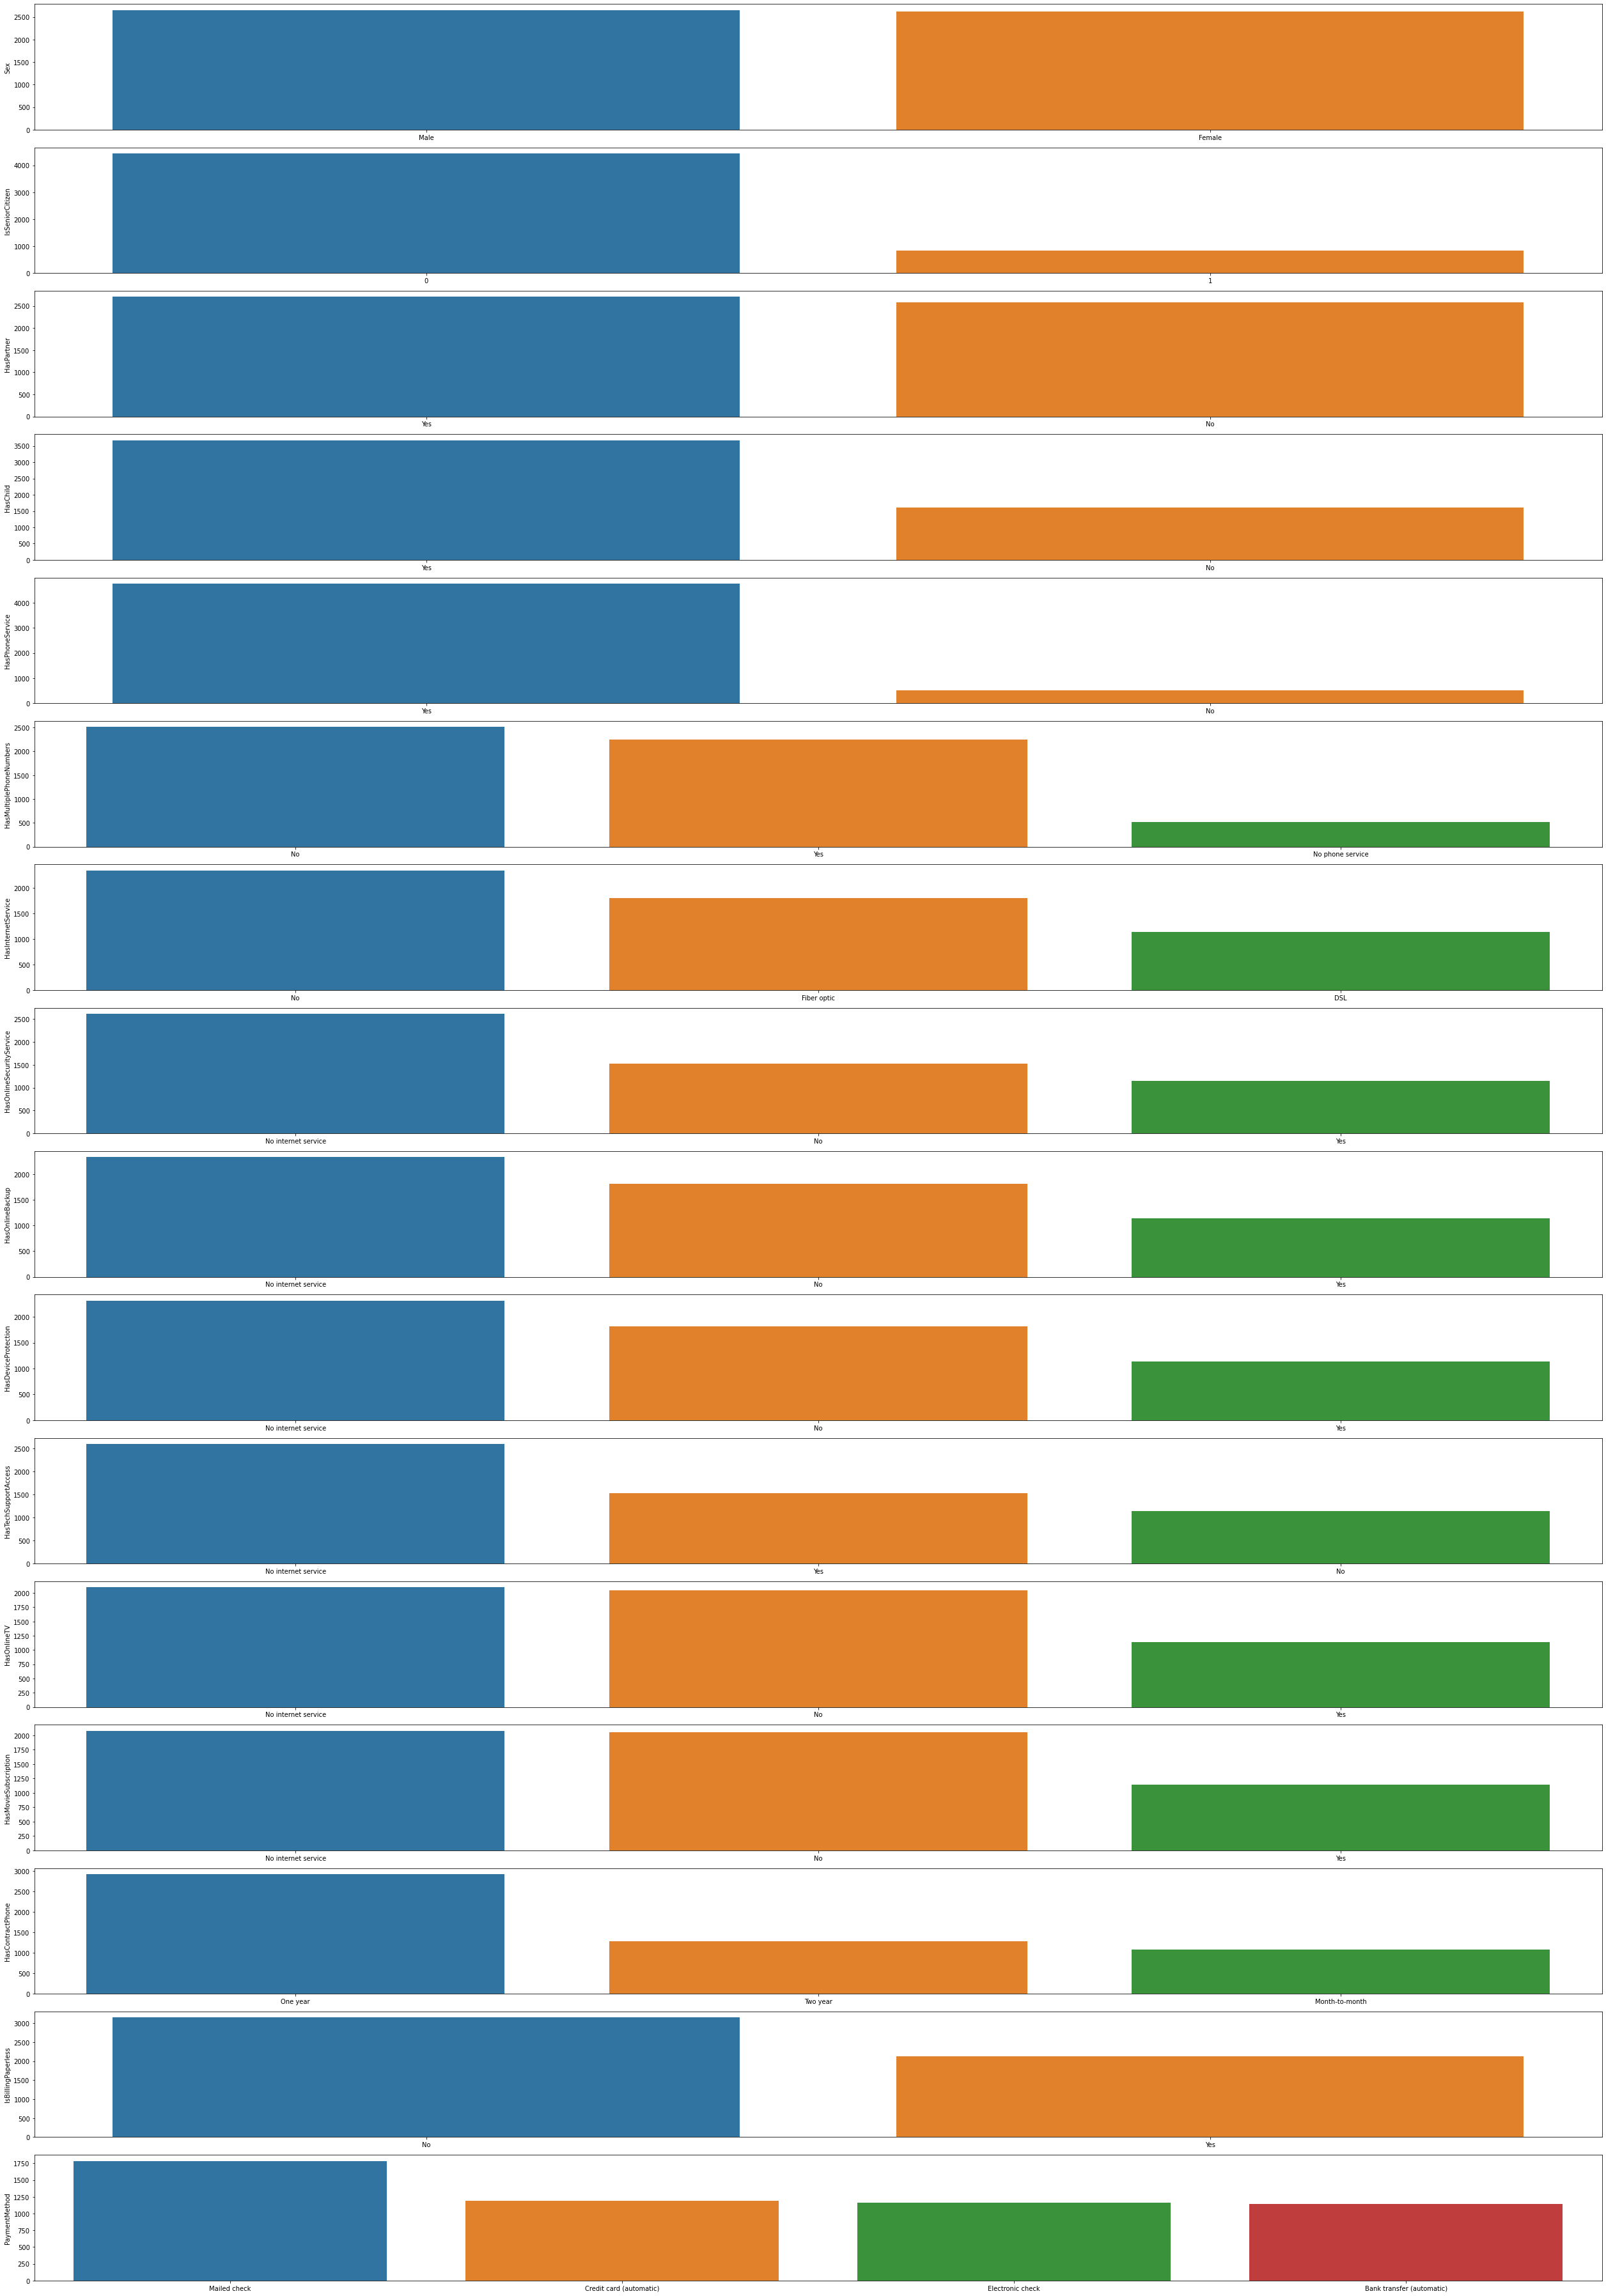

In [10]:
# Визуализируем категориальные признаки с помощью barplot
fig, axs = plt.subplots(16, figsize=(35, 50))
for i, plot in enumerate(cat_cols):
  sns.barplot(x=data[plot].unique(), y= data[plot].value_counts(), data=data[cat_cols],ax=axs[i])
  plt.tight_layout()

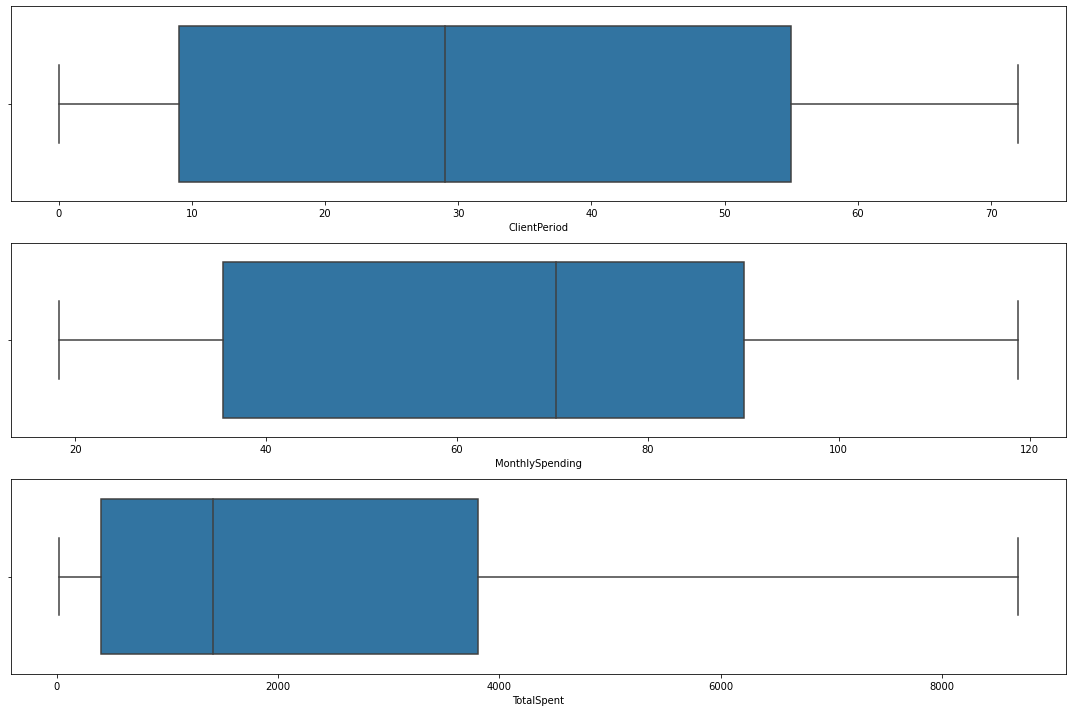

In [11]:
# Визуализируем численные признаки с помощью boxplot
fig, axs = plt.subplots(3, figsize=(15, 10))
for i, plot in enumerate(num_cols):
  sns.boxplot(x=data[plot], data=data[num_cols],ax=axs[i])
  plt.tight_layout()

(Дополнительно) Если вы нашли какие-то ошибки в данных или выбросы, то можете их убрать. Тут можно поэксперементировать с обработкой данных как угодно, но не за баллы.

In [12]:
# удалим строки, где 'TotalSpent' отсутствует
dada = data.dropna(subset=['TotalSpent'], inplace=True)

In [13]:
# теперь пропусков нет
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5273 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5273 non-null   int64  
 1   MonthlySpending           5273 non-null   float64
 2   TotalSpent                5273 non-null   float32
 3   Sex                       5273 non-null   object 
 4   IsSeniorCitizen           5273 non-null   int64  
 5   HasPartner                5273 non-null   object 
 6   HasChild                  5273 non-null   object 
 7   HasPhoneService           5273 non-null   object 
 8   HasMultiplePhoneNumbers   5273 non-null   object 
 9   HasInternetService        5273 non-null   object 
 10  HasOnlineSecurityService  5273 non-null   object 
 11  HasOnlineBackup           5273 non-null   object 
 12  HasDeviceProtection       5273 non-null   object 
 13  HasTechSupportAccess      5273 non-null   object 
 14  HasOnlin

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [16]:
# Отделяем таргет от признаков
y = data['Churn']
X = data.drop(['Churn'], axis=1)

In [17]:
# Создаем пайплайн для категориальных признаков: OrdinalEncode + OneHotEncoder
# Масштабируем количественные признаки:  StandardScaler
# Это все относится к предобработке данных для Логистической регрессии
cat_transformer = Pipeline(steps=[
    ('encoder_1', OrdinalEncoder()),
    ('encoder_2', OneHotEncoder())])


num_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)])

pip = Pipeline(steps=[('preprocessor', preprocessor),
                      ('clf', LogisticRegression())])

In [18]:
# # Поиск лучших параметров будем осущетсвлять с помощью GridSearch
# find_params = {'clf__C': [100, 10, 1, 0.1, 0.01, 0.001],
#           'clf__penalty': ['l1','l2', 'elasticnet'],
#           'clf__solver': ['lbfgs', 'liblinear']
#           }
# # Поиск лучших
# model_grid = GridSearchCV(estimator=pip, param_grid=find_params, scoring='roc_auc', cv=5)
# model_grid.fit(X, y)
# # Смотрим лушие параметры
# model_grid.best_params_

In [21]:
# Лучшие параметры
params = {'Cs': 10, 
          'penalty': 'l1', 
          'solver': 'liblinear'}

In [22]:
# Пайплайн с кросс-валидацией
pip_logreg = Pipeline(steps=[('preprocessor', preprocessor),
                              ('clf', LogisticRegressionCV(Cs = 10, penalty = 'l1', solver = 'liblinear', 
                                                           cv=5, random_state=42, scoring='roc_auc'))])

In [23]:
pip_logreg.fit(X,y)
print("score", pip_logreg.score(X, y))

score 0.8487873199494054


Выпишите какое лучшее качество и с какими параметрами вам удалось получить

## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [25]:
# # Подбираем параметры для CatBoostClassifier
# params = {'iterations': [100, 150, 200, 300], 
#           'depth': [3, 4, 5, 6, 7, 8],
#           'learning_rate': [0.03, 0.04, 0.05, 0.06, 0.09]
#          }

In [26]:
# CatboostClassifier
model = CatBoostClassifier( 
                           cat_features=cat_cols,
                           auto_class_weights='Balanced', 
                           verbose=1,
                           random_seed=42,
                           bootstrap_type='Bernoulli'
                           )

In [27]:
# # поиск лучших будем осуществлять по сетке
# model_grid = GridSearchCV(estimator=model, param_grid=params, scoring='roc_auc', cv=5, verbose=1)
# model_grid.fit(X, y)
# # Лучшие параметры
# model_grid.best_params_

In [29]:
# Лучшие параметры 
best_params = {'depth': 3, 'iterations': 300, 'learning_rate': 0.04}


In [30]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [31]:
# CatBoostClassifier с лучшими параметрами
cat_model = CatBoostClassifier( 
                          eval_metric = 'AUC',
                           cat_features=cat_cols,
                           auto_class_weights='Balanced', 
                           random_seed=42,
                           **best_params)

In [ ]:
cat_model.fit(X_train, y_train)
preds_val = cat_model.predict_proba(X_val)[:, 1]
print("score", roc_auc_score(y_val, preds_val))
None

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

# Стекинг

In [41]:
# В качестве признака будем использовать предсказанные значения вероятности 1-го класса с помощью Логистической регрессии
L = pip_logreg.predict_proba(X)
pred_log = pd.DataFrame(L[:,1], columns=['Logreg_predict_proba'])

In [45]:
pred_log.index = X.index

In [ ]:
# Добавляем признаки, а в качестве модели используем CatBoostClasifier
s = pd.concat((X, pred_log), axis=1)

In [48]:
n_scores = cross_val_score(cat_model, s, y, scoring='roc_auc', cv=5, n_jobs=-1)
np.mean(n_scores)

0.8493003115586406

# Предсказания

In [49]:
X_test = pd.read_csv('./test_dls3.csv')

In [51]:
# Проделываем то же самое с тестовым датасетом
X_test = X_test.replace(' ', np.NaN)
X_test['TotalSpent'] = pd.to_numeric(X_test['TotalSpent'], downcast='float')
X_test['TotalSpent'].fillna(X_test['TotalSpent'].median(), inplace=True)

In [54]:
T = pip_logreg.predict_proba(X_test)
log_pred_T = pd.DataFrame(T[:,1], columns=['Logreg_predict_proba'])
s_T = pd.concat((X_test, log_pred_T), axis=1)

In [56]:
best_model = cat_model

In [57]:
submission = pd.read_csv('./submission_dls3.csv')
submission['Churn'] = best_model.predict_proba(s_T)[:, 1]
submission.to_csv('./my_submission.csv', index=False)

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.